In [0]:
# use following command to make colab connect google drive
#The maximum lifetime of a Colab VM is 12 hours.
!dpkg --configure -a
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty

In [0]:
#load the json data
import os
import json
data_path = '/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/data/'
data_exist=os.path.exists(data_path)
labels = list()
document_list = list()
k=1
if data_exist:
  print('Data exist')
  file_names = os.listdir(data_path)
  for i in range(len(file_names)):
      print(file_names[i])
      file_path = data_path+file_names[i]
      print(file_path)
      with open(file_path,encoding="utf8", errors='ignore') as f:
        data = json.load(f)
        paragraphs = list()
        for item in data['text'].values():
          if len(item) < 524288:
            new_row = {'id': k, 'language': 'en', 'text':item}
            print(new_row)
            k = k+1
            paragraphs.append(new_row)
        documents = {'documents' :paragraphs}
        document_list.append(documents)
        for item in data['sentiment'].values():
          if item =="Neutral":
            labels.append(0)
          elif item == "Positive":
            labels.append(1)
          else:
            labels.append(-1)

In [0]:
# load the pickle data
import pickle
obj = pickle.load(open("/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/all_group_data.pickle", "rb"))
# print(obj)
k=0
num=1
labels=[]
document_list = list()
for i in range(0,3):
  paragraphs = list()
  for item in obj[k:k+644].values:
    labels.append(item[2])
    new_row = {'id': num, 'language': 'en', 'text':item[1]}
    num = num+1
    paragraphs.append(new_row)
#     print(new_row)
  k=k+644
  documents = {'documents' :paragraphs}
  document_list.append(documents)

In [0]:
# use Microsoft text api to analyze sentiment
import requests
subscription_key = "04428434373c44de8e5d6a200d528415"
text_analytics_base_url = "https://westcentralus.api.cognitive.microsoft.com/text/analytics/v2.0/"
sentiment_api_url = text_analytics_base_url + "sentiment"
print(sentiment_api_url)

https://westcentralus.api.cognitive.microsoft.com/text/analytics/v2.0/sentiment


In [0]:
import pandas as pd
score_list = list()
for item in document_list:
  headers   = {"Ocp-Apim-Subscription-Key": subscription_key}
  response  = requests.post(sentiment_api_url, headers=headers, json=item)
  sentiments = response.json()
  for item in sentiments['documents']:
    if item['score']== 0.5:
      score_list.append(item['score'])
    elif item['score']>0.5:
      score_list.append(item['score'])
    else:
      score_list.append(item['score'])
      
file_name = "/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/result/microsoft.csv"

df =  pd.DataFrame({'scores':score_list,'orginal_label':labels})
df.to_csv(file_name,index=False)

In [0]:
print(df)

     orginal_label    scores
0          neutral  0.500000
1          neutral  0.500000
2         negative  0.500000
3          neutral  0.500000
4          neutral  0.500000
5          neutral  0.500000
6          neutral  0.500000
7          neutral  0.848863
8          neutral  0.500000
9          neutral  0.790459
10         neutral  0.199887
11         neutral  0.752954
12         neutral  0.500000
13        positive  0.500000
14         neutral  0.500000
15         neutral  0.500000
16         neutral  0.500000
17         neutral  0.500000
18         neutral  0.500000
19        positive  0.500000
20         neutral  0.500000
21         neutral  0.500000
22         neutral  0.500000
23         neutral  0.500000
24         neutral  0.500000
25         neutral  0.500000
26         neutral  0.500000
27         neutral  0.500000
28         neutral  0.500000
29         neutral  0.731781
...            ...       ...
1614       neutral  0.754378
1615       neutral  0.850092
1616       neu

Confusion matrix, without normalization
[[ 20  79  56]
 [ 45 466 324]
 [ 40 309 305]]


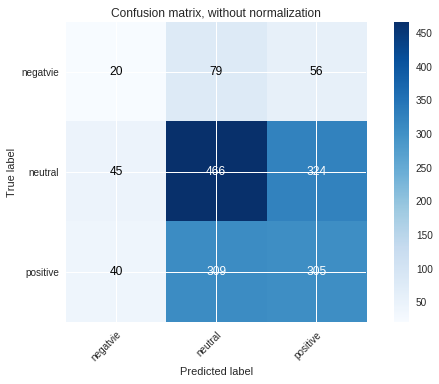

In [0]:
# calculate and print the confusion matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


class_names = ['negatvie','neutral','positive']
# class_names = ['positive','neutral','negatvie']

# Plot non-normalized confusion matrix
plot_confusion_matrix(df['orginal_label'], df['scores'], classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(df['orginal_label'], df['scores'], classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()


In [0]:
# Use IBM API to analyze sentiment
!pip install --upgrade "watson-developer-cloud>=2.5.1"
import json
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, SentimentOptions

    100% |████████████████████████████████| 286kB 11.9MB/s 
    100% |████████████████████████████████| 204kB 27.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/f3/1d/4f/5a5432c03a3c28c79e41bbf7110b871a88bab10393906b86fe
Successfully built watson-developer-cloud


In [0]:
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2018-11-16',
    iam_apikey='hROMpJC1F5AjCmYKNp0A-jh-bjzGEVhlpk6tyg5Y-zf3',
    url='https://gateway-wdc.watsonplatform.net/natural-language-understanding/api'
)

In [0]:
labels=[]
score_list = list()
for item in obj.values:
  labels.append(item[2])
  print(item[1])
  try:
    response = natural_language_understanding.analyze(
      text= item[1],
      features=Features(sentiment=SentimentOptions())).get_result()
  except Exception:
    score = 0
  score = response['sentiment']['document']['score']
  print(score)
  score_list.append(score)

Could you catch us up on your latest thinking on the NMA? And maybe tie that to your view on moderating demand, I guess, if -- demand would obviously fluctuate a bit if you chose to launch the aircraft with the pile of launch customers, I would imagine. So maybe just juxtapose those two different points.
-0.55131
We continue to ramp up the activities for the T-X and MQ-25 programs. These wins are the culmination of years of unwavering focus, improving our technology and derisking the programs. We have developed and flight tested two all-new production ready T-X jets with 76 flight tests having been completed to date. We've already seeing strong interest as well for the T-X from outside of the U.S. On MQ-25, we have demonstrated deck handling and engine trials. Our MQ-25 prototype aircraft is currently in ground test and expected to undergo first flight this year.
0.532399
Yes, it was sort of just how the conversation is going through your customers preliminarily at least around this pl

In [0]:
import pandas as pd
file_name = "/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/result/ibm.csv"
df =  pd.DataFrame({'scores':score_list,'orginal_label':labels})
df.to_csv(file_name,index=False)

In [0]:
score_labels = list()
for item in df['scores']:
  if item<0.5:
    score_labels.append("negative")
  elif item==0.5:
    score_labels.append("neutral")
  else:
    score_labels.append("positive")

Confusion matrix, without normalization
[[ 79   0  76]
 [365   0 470]
 [106   0 548]]


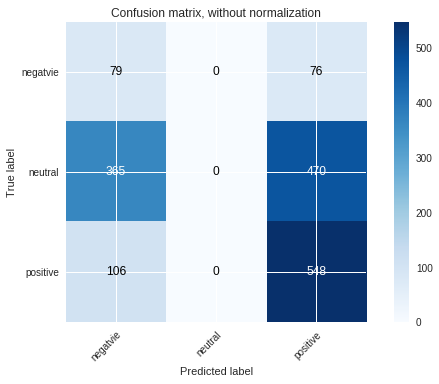

In [0]:
# calculate and print the confusion matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


class_names = ['negatvie','neutral','positive']
# class_names = ['positive','neutral','negatvie']

# Plot non-normalized confusion matrix
plot_confusion_matrix(df['orginal_label'],score_labels, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(df['orginal_label'], df['scores'], classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()
